<img src="https://bit.ly/2VnXWr2" width="100" align="left">

# Project | ML: Job offers' Fraud-Detection with NLP

## Introduction

In order to experience how to work in a ML project as a group, and to learn more on NLP we have been working on this dataset from Kaggle, [[Real or Fake] Fake Job Posting Prediction](https://www.kaggle.com/shivamb/real-or-fake-fake-jobposting-prediction), that holds around 18K job descriptions out of which about 900 are fake. The data consists of both textual information and meta-information about the jobs. 

### Objectives

 We mainly wanted to create a **classification model using text data features and meta-features to predict which job descriptions are fraudulent**. As well as, finding out if there are **key traits/features** (words, entities, phrases) of job descriptions which are **intrinsically fraudulent**.

### Imports

In [158]:
import pandas as pd
import numpy as np

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Data Visualization for text
from PIL import Image
from os import path
import os
import random
from wordcloud import WordCloud, STOPWORDS

# Load/Save heavy objects
import pickle

# Text Processing
import re
import itertools
import spacy
import string
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
from collections import Counter

# Dimension reduction
import umap

# Machine Learning packages
# Preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.under_sampling import InstanceHardnessThreshold
from sklearn.model_selection import train_test_split
# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
# Model evaluation
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Ignore noise warning
import warnings
warnings.filterwarnings('ignore')

## 1. Exploratory Data Analysis

### Context

As said above, we've worked on a dataset of job descriptions and their meta information in which a small proportion of these descriptions were fake or scam, which can be identified by the column "fraudulent".

**Columns**:
* `job_id` Unique Job ID
* `title` The title of the job ad entry.
* `location` Geographical location of the job ad.
* `department` Corporate department (e.g. sales).f
* `salary_range` Indicative salary range (e.g. $50,000-$60,000)
* `company_profile` A brief company description.
* `description` The details description of the job ad.
* `requirements` Enlisted requirements for the job opening.
* `benefits` Enlisted offered benefits by the employer.
* `telecommuting` True for telecommuting positions.
* `has_company_logo` True if company logo is present.
* `has_questions` True if screening questions are present.
* `employment_type` Full-type, Part-time, Contract, etc.
* `required_experience` Executive, Entry level, Intern, etc.
* `required_education` Doctorate, Master’s Degree, Bachelor, etc.
* `industry Automotive` IT, Health care, Real estate, etc.
* `function Consulting` Engineering, Research, Sales etc.
* `fraudulent` **target** Classification attribute

### Global EDA

#### Read dataset and check head

In [2]:
data = pd.read_csv("data/fake_job_postings.csv")
data.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


#### Check shape

In [3]:
data.shape

(17880, 18)

#### Check dtypes and columns

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
job_id                 17880 non-null int64
title                  17880 non-null object
location               17534 non-null object
department             6333 non-null object
salary_range           2868 non-null object
company_profile        14572 non-null object
description            17879 non-null object
requirements           15185 non-null object
benefits               10670 non-null object
telecommuting          17880 non-null int64
has_company_logo       17880 non-null int64
has_questions          17880 non-null int64
employment_type        14409 non-null object
required_experience    10830 non-null object
required_education     9775 non-null object
industry               12977 non-null object
function               11425 non-null object
fraudulent             17880 non-null int64
dtypes: int64(5), object(13)
memory usage: 2.5+ MB


#### Check nulls

In [5]:
data.isna().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

#### Check duplicates

In [6]:
data.duplicated().sum()

0

#### Check uniques

In [7]:
data.nunique()

job_id                 17880
title                  11231
location                3105
department              1337
salary_range             874
company_profile         1709
description            14801
requirements           11968
benefits                6205
telecommuting              2
has_company_logo           2
has_questions              2
employment_type            5
required_experience        7
required_education        13
industry                 131
function                  37
fraudulent                 2
dtype: int64

#### Target variable distribution

In [8]:
data.fraudulent.value_counts()

0    17014
1      866
Name: fraudulent, dtype: int64

### Numerical columns

In [9]:
data.describe()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,8940.500000,0.042897,0.795302,0.491723,0.048434
std,5161.655742,0.202631,0.403492,0.499945,0.214688
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4470.750000,0.000000,1.000000,0.000000,0.000000
50%,8940.500000,0.000000,1.000000,0.000000,0.000000
75%,13410.250000,0.000000,1.000000,1.000000,0.000000
max,17880.000000,1.000000,1.000000,1.000000,1.000000


At first we only got 5 numerical columns being one of them an index ("job_id").

#### See some descriptive statistics of numerical variables

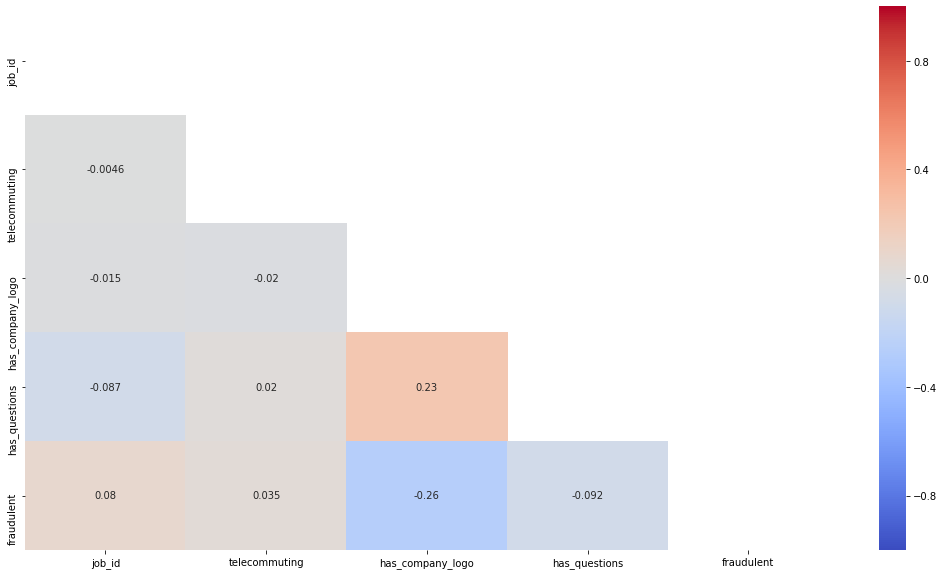

In [10]:
mask = np.triu(np.ones_like(data.corr(), dtype=np.bool))
plt.figure(figsize=(18,10))
sns.heatmap(data.corr(), mask=mask, cmap='coolwarm', annot=True, vmin=-1, vmax=1) 

plt.show()

#### Comments

With the raw data we can only find a single correlationship with the target "fraudulent" that is somewhat significative:
*  It seems it is slightly more common for fraudulent job offers to not contain the company logo, though the relationship is of `-0.26`.

### Categorical variables

#### Visualization

In [11]:
data_1 = data.copy()

We will use countplots to visualize most common words in categorical columns, which are not whole sentences/paragraphs, from fraudulent offers against real ones.

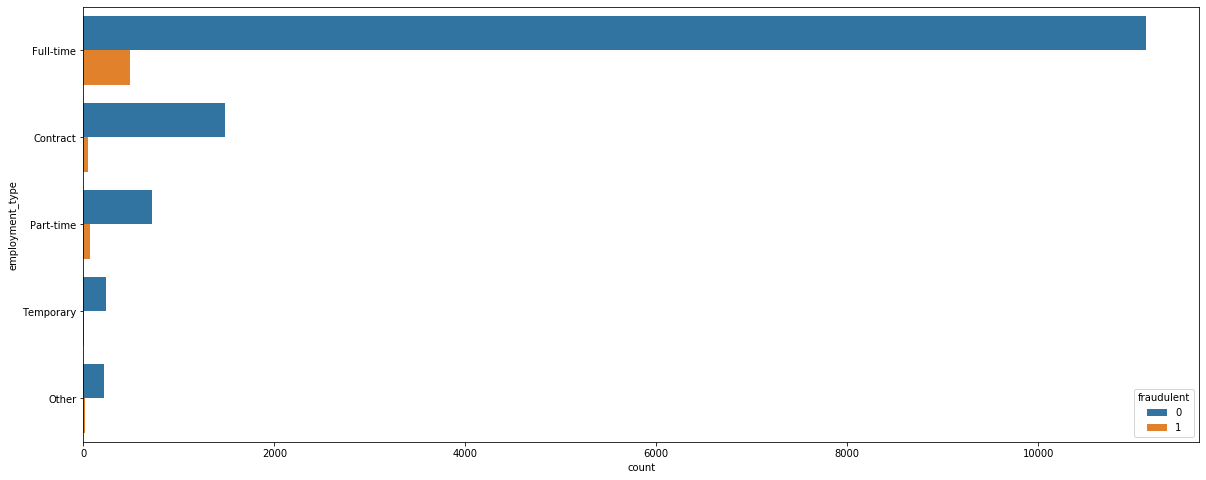

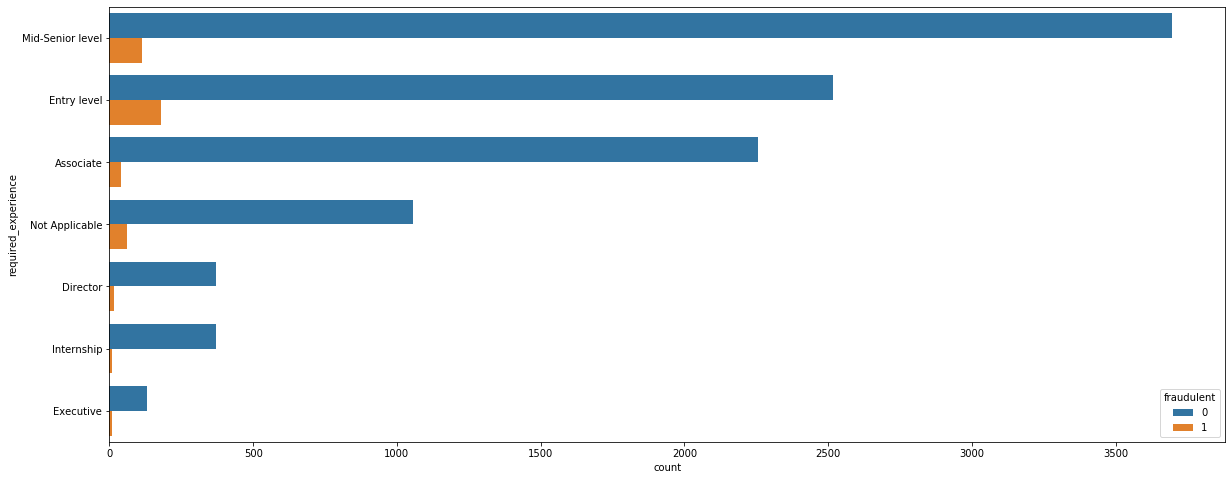

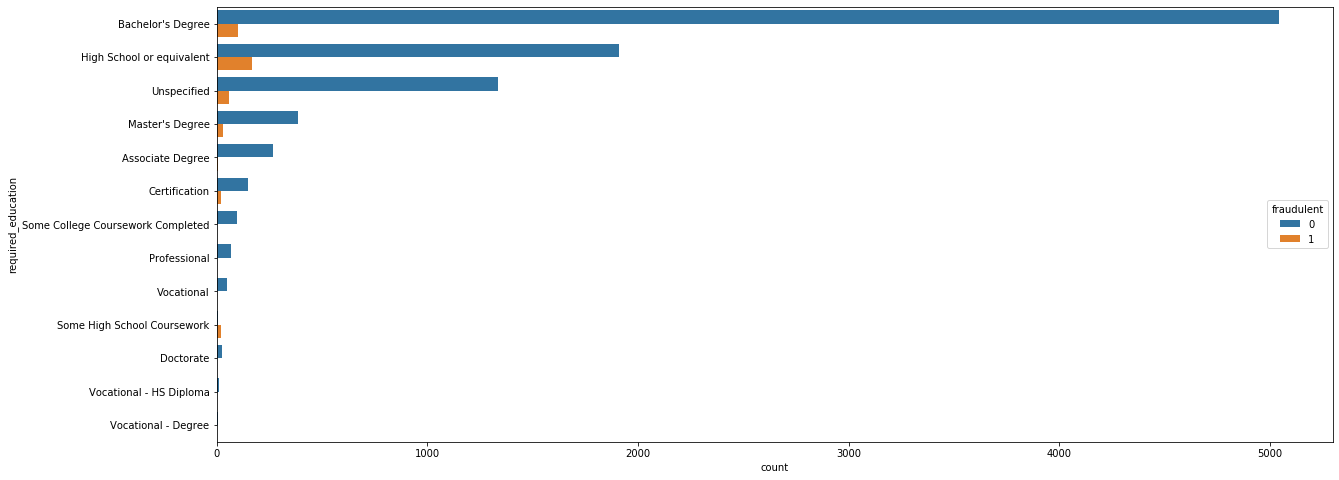

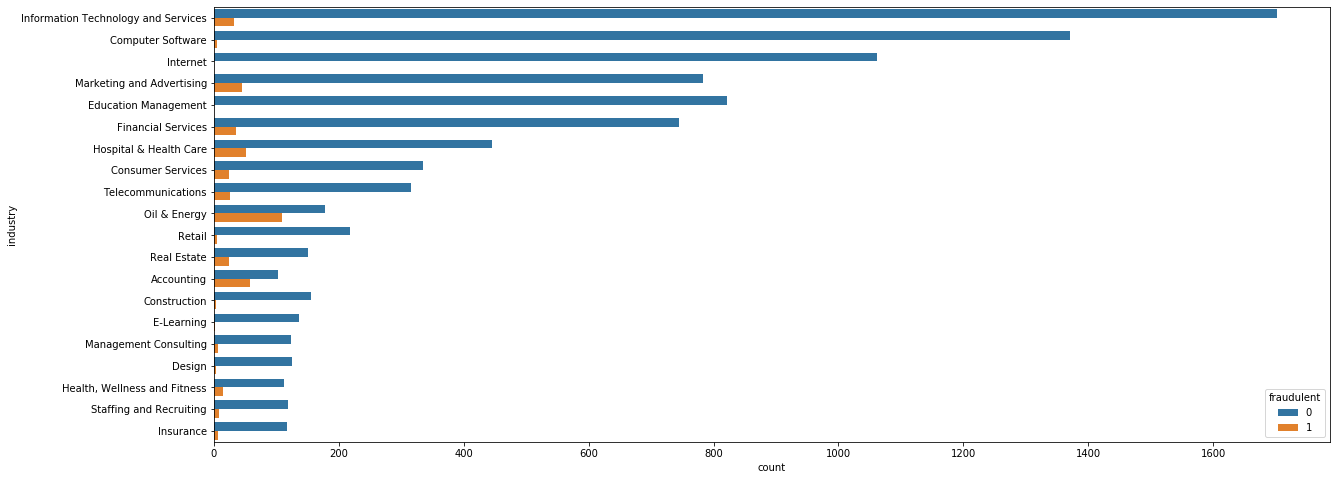

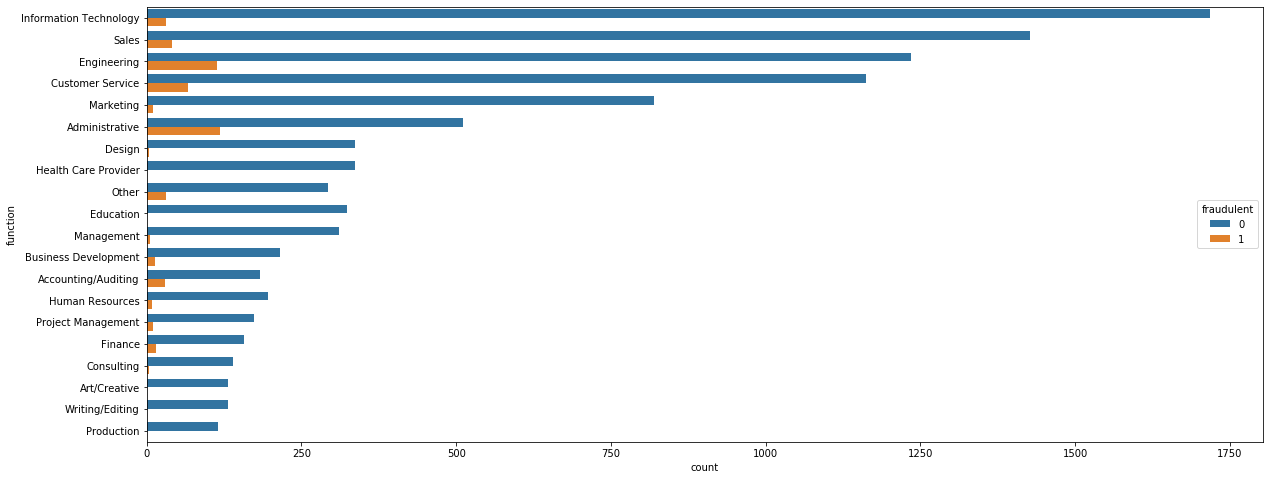

In [12]:
fig, ax = plt.subplots(figsize=(20,8))
ax = sns.countplot(hue="fraudulent",y="employment_type",data=data_1,
                   order=data_1.employment_type.value_counts().iloc[:20].index)

fig, ax = plt.subplots(figsize=(20,8))
ax = sns.countplot(hue="fraudulent",y="required_experience",data=data_1,
                   order=data_1.required_experience.value_counts().iloc[:20].index)
              
fig, ax = plt.subplots(figsize=(20,8))              
ax = sns.countplot(hue="fraudulent",y="required_education",data=data_1,
                   order=data_1.required_education.value_counts().iloc[:20].index)
              
fig, ax = plt.subplots(figsize=(20,8))              
ax = sns.countplot(hue="fraudulent",y="industry",data=data_1,
                   order=data_1.industry.value_counts().iloc[:20].index)

fig, ax = plt.subplots(figsize=(20,8))              
ax = sns.countplot(hue="fraudulent",y="function",data=data_1,
                   order=data_1.function.value_counts().iloc[:20].index)


plt.show()

We will use wordclouds to visualize most common words in categorical columns which are whole sentences/paragraphs from fraudulent offers.

In [13]:
data_1 = data_1.loc[data_1["fraudulent"]==1]

In [14]:
for value in data_1[["title","department","company_profile","description","requirements","benefits"]]:
    data_1[value]= data_1[value].astype(str, errors="ignore")

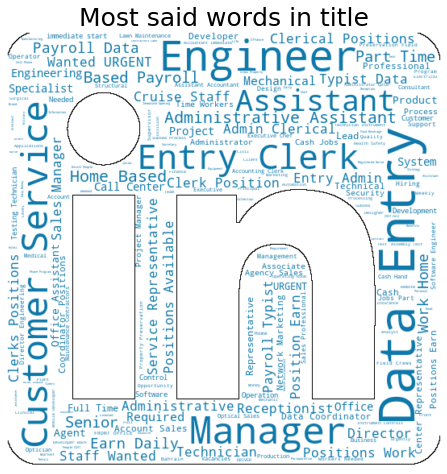

In [15]:
def grey_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return "rgb(14, 120, 170)"

d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

text = " ".join(data_1["title"])

mask = np.array(Image.open(path.join(d, "images/LI-In-Bug.png")))

stopwords = set(STOPWORDS)

wc = WordCloud(background_color="white", width=800, height=400, stopwords=stopwords, max_words=1000,
               repeat=False, min_word_length=4, mask=mask, contour_width=1)

wc.generate(text)

wc.to_file(path.join(d, "images/output_images/linkedin_logo.png"))

plt.figure(figsize=(20,8))
plt.imshow(wc.recolor(color_func=grey_color_func, random_state=3), interpolation='bilinear')
plt.axis("off")
plt.title("Most said words in title", fontsize=25)
plt.show()

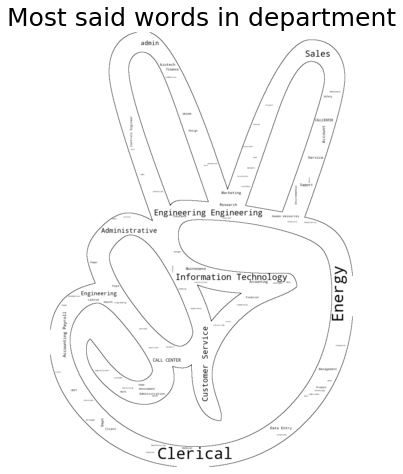

In [16]:
def grey_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return "rgb(1, 1, 1)"

d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

text = " ".join(data_1["department"])

mask = np.array(Image.open(path.join(d, "images/AngelList_Black_Victory_Hand.png")))

stopwords = set(STOPWORDS)

wc = WordCloud(background_color="white", width=800, height=400, stopwords=stopwords, max_words=1000,
               repeat=False, min_word_length=4, mask=mask, contour_width=1)

wc.generate(text)

wc.to_file(path.join(d, "images/output_images/angellist_logo.png"))

plt.figure(figsize=(20,8))
plt.imshow(wc.recolor(color_func=grey_color_func, random_state=3), interpolation='bilinear')
plt.axis("off")
plt.title("Most said words in department", fontsize=25)
plt.show()

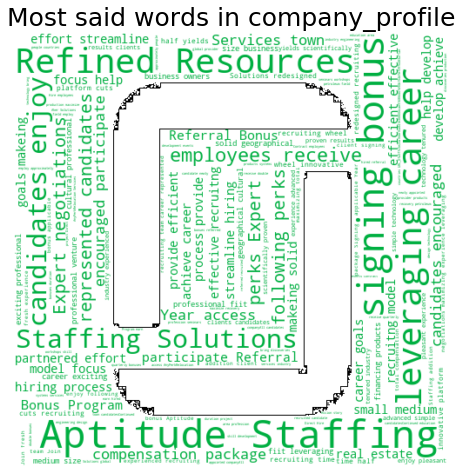

In [17]:
def grey_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return "rgb(0, 175, 65)"

d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

text = " ".join(data_1["company_profile"])

mask = np.array(Image.open(path.join(d, "images/glassdoor-socialicon-rgb.jpg")))

stopwords = set(STOPWORDS)

wc = WordCloud(background_color="white", width=800, height=400, stopwords=stopwords, max_words=1000,
               repeat=False, min_word_length=4, mask=mask, contour_width=1)

wc.generate(text)

wc.to_file(path.join(d, "images/output_images/glassdoor_logo.png"))

plt.figure(figsize=(20,8))
plt.imshow(wc.recolor(color_func=grey_color_func, random_state=1), interpolation='bilinear')
plt.axis("off")
plt.title("Most said words in company_profile", fontsize=25)
plt.show()

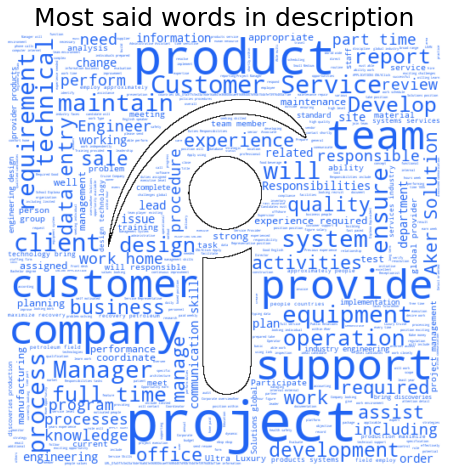

In [18]:
def grey_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return "rgb(33, 100, 243)"

d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

text = " ".join(data_1["description"])

mask = np.array(Image.open(path.join(d, "images/Indeed_logo.png")))

stopwords = set(STOPWORDS)

wc = WordCloud(background_color="white", width=800, height=400, stopwords=stopwords, max_words=1000,
               repeat=False, min_word_length=4, mask=mask, contour_width=1)

wc.generate(text)

wc.to_file(path.join(d, "images/output_images/indeed_logo.png"))

plt.figure(figsize=(20,8))
plt.imshow(wc.recolor(color_func=grey_color_func, random_state=1), interpolation='bilinear')
plt.axis("off")
plt.title("Most said words in description", fontsize=25)
plt.show()

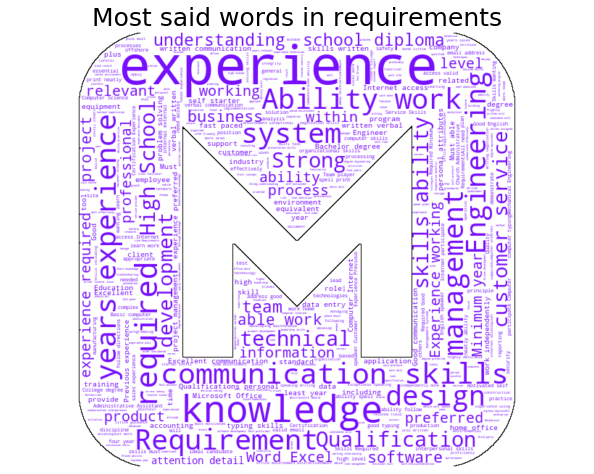

In [19]:
def grey_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return "rgb(119, 14, 253)"

d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

text = " ".join(data_1["requirements"])

mask = np.array(Image.open(path.join(d, "images/moster_logo.png")))

stopwords = set(STOPWORDS)

wc = WordCloud(background_color="white", width=800, height=400, stopwords=stopwords, max_words=1000,
               repeat=False, min_word_length=4, mask=mask, contour_width=1)

wc.generate(text)

wc.to_file(path.join(d, "images/output_images/monster_logo.png"))

plt.figure(figsize=(20,8))
plt.imshow(wc.recolor(color_func=grey_color_func, random_state=1), interpolation='bilinear')
plt.axis("off")
plt.title("Most said words in requirements", fontsize=25)
plt.show()

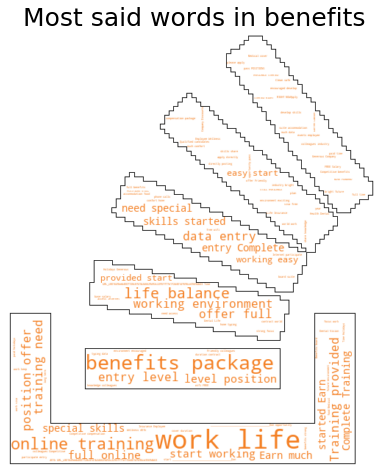

In [20]:
def grey_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return "rgb(244, 128, 36)"

d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

text = " ".join(data_1["benefits"])

mask = np.array(Image.open(path.join(d, "images/stackoverflow_logo.PNG")))

stopwords = set(STOPWORDS)

wc = WordCloud(background_color="white", width=800, height=400, stopwords=stopwords, max_words=1000,
               repeat=False, min_word_length=4, mask=mask, contour_width=1)

wc.generate(text)

wc.to_file(path.join(d, "images/output_images/stackoverflow_logo.png"))

plt.figure(figsize=(20,8))
plt.imshow(wc.recolor(color_func=grey_color_func, random_state=1), interpolation='bilinear')
plt.axis("off")
plt.title("Most said words in benefits", fontsize=25)
plt.show()

#### Comments

It seems there is terms that are more frequent than others but we still can't establish any sort of relationship between those terms' frequencies and our target variable, or at least, we can't with those categorical variables where there are far too many unique values.

### Categorical columns: Text and lots of uniques 

In order to better appreciate if it may be a relationship between variables of pure text where there is plenty of different unique values, we will tokenize text columns' content to form a Bag of Words.

#### BoW

In [21]:
data_text = data[['job_id', 'title','department', 'company_profile', 'description', 'requirements', 'benefits']].copy()

In [22]:
data_text = data_text.fillna('')
text_columns = data_text[['job_id']]
text_columns['text'] = data_text.iloc[:,1:].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

C:\Users\unoma\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [23]:
def clean_urls(column):
    '''
    This function takes a string and returns a string 
    with its urls removed and all the words in lowercase.
    '''
    return column.apply(lambda x: x.lower()).apply(lambda x: re.sub('http[s]?://\S+', '', x))

text_columns['text'] = clean_urls(text_columns['text'])

C:\Users\unoma\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [24]:
raise SystemExit("Stop right there! Run cells one by one till the end of this notebook.")

SystemExit: Stop right there! Run cells one by one till the end of this notebook.

C:\Users\unoma\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3334: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [92]:
nlp = spacy.load('en_core_web_sm', disable = ['ner', 'parser']) 
nlp.max_length = 33000000

In [26]:
def tokenize(string):
    '''
    This function takes a sentence and returns the list of all lemma
    '''
    doc = nlp(string)
    l_token = [token.text for token in doc if not token.is_punct 
               | token.is_space | token.is_stop | token.is_digit & token.is_oov]
    return ' '.join(l_token)


text_columns['text'] = text_columns['text'].apply(lambda row: tokenize(row))

C:\Users\unoma\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [27]:
pd_token = pd.DataFrame(text_columns, columns=['job_id', 'text'])
pd_token.head()

,job_id,text
0,1,marketing intern marketing food52 created grou...
1,2,customer service cloud video production succes...
2,3,commissioning machinery assistant cma valor se...
3,4,account executive washington dc sales passion ...
4,5,bill review manager spotsource solutions llc g...


In [28]:
pd_token.to_pickle("data/output_pickles/token.pkl")

#### Visualization

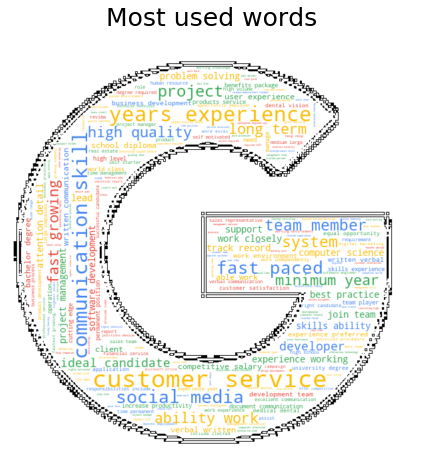

In [29]:
colors = ["rgb(52, 168, 83)", "rgb(251, 188, 5)", "rgb(66, 133, 244)", "rgb(234, 67, 53)"]
def grey_color_func(word, font_size, position, orientation, random_state=1,**kwargs):
    return random.choice(colors)

d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

text = "".join(pd_token["text"])

mask = np.array(Image.open(path.join(d, "images/logo_google.png")))

stopwords = set(STOPWORDS)

wc = WordCloud(background_color="white", width=800, height=400, stopwords=stopwords, max_words=1000,
               repeat=False, min_word_length=4, mask=mask, contour_width=1)

wc.generate(text)

wc.to_file(path.join(d, "images/output_images/google_logo.png"))

plt.figure(figsize=(20,8))
plt.imshow(wc.recolor(color_func=grey_color_func, random_state=1), interpolation='bilinear')
plt.axis("off")
plt.title("Most used words", fontsize=25)
plt.show()

#### Comments

After tokenizing we can se that there's words or short expressions which are more common than others in "text" columns but there's still too much information and it is too raw as to get interesting insights from it.

## 2. Data preprocessing

### Categorical

Categorical refers to columns of categorical variables which are not whole sentences/paragraphs.

In [30]:
categorical_columns = data[["job_id","employment_type", "required_experience", 
                            "required_education", "industry", "function"]].copy()

In [31]:
categorical_columns = categorical_columns.fillna("other")


In [32]:
for column in categorical_columns.columns[1:]:
    categorical_columns[column] = categorical_columns[column].str.lower()

In [33]:
unique_industries_percentage = categorical_columns['industry'].value_counts()/categorical_columns.shape[0]*100

unique_industries_indexes = list(unique_industries_percentage[unique_industries_percentage >= 1].index)

other_industry = categorical_columns["industry"][~categorical_columns["industry"].isin(unique_industries_indexes)].unique()

categorical_columns["industry"].replace(other_industry,"other", inplace=True)

In [34]:
vals_to_replace = {"not applicable":"other", "mid-senior level":"associate", "director":"executive"}
categorical_columns["required_experience"] = categorical_columns["required_experience"].replace(vals_to_replace)


vals_to_replace = {"information technology and services":"information technologies","internet":"information technologies",
                   "computer software":"information technologies", "telecommunications":"information technologies"}

categorical_columns["industry"] = categorical_columns["industry"].replace(vals_to_replace)


vals_to_replace = {"unspecified":"other","some high school coursework":"high school or equivalent",
                   "vocational - hs diploma":"high school or equivalent", "mid-senior level":"associate",
                   "some college coursework completed":"associate degree", "professional":"vocational",
                   "vocational - degree":"vocational","certification":"vocational"}

categorical_columns["required_education"] = categorical_columns["required_education"].replace(vals_to_replace)


vals_to_replace = {"design":"marketing", "public relations":"marketing", "advertising":"marketing", "art/creative":"marketing", 
                   "financial analyst":"finance", "accounting/auditing":"finance","financial analyst":"finance",
                   "training":"human resources","data analyst":"information technology","supply chain":"production",
                   "manufacturing":"production", "quality assurance":"production","project management":"management",
                   "product management":"management", "strategy/planning": "management","sales":"business development",
                   "general business":"business development", "business analyst":"business development",
                   "purchasing":"business development","research":"research and development",
                   "science":"research and development"}

categorical_columns["function"] = categorical_columns["function"].replace(vals_to_replace)


In [35]:
# Split of localitation column

# new data frame with split value columns 
new = data["location"].str.split(",", n = 2, expand = True) 
  
# making separate columns from new data frame 
data["Country"]= new[0] 
data["Region"]= new[1]
data["City"] = new[2]


data['Country'].value_counts() # La distribución del 3r contry es menor a mil, y luego baja en picado.
top_countries = data['Country'].value_counts().head(4).index
other_countries = data['Country'][~data['Country'].isin(top_countries)].unique()

data['Country'].replace(other_countries, 'OTHER', inplace=True)

categorical_columns.loc[:,'Country'] = data.loc[:,'Country']

In [36]:
categorical_columns_dummies = pd.get_dummies(categorical_columns, columns = categorical_columns.columns[1:])

In [37]:
categorical_columns_dummies.head()

,job_id,employment_type_contract,employment_type_full-time,employment_type_other,employment_type_part-time,employment_type_temporary,required_experience_associate,required_experience_entry level,required_experience_executive,required_experience_internship,...,function_marketing,function_other,function_production,function_research and development,function_writing/editing,Country_CA,Country_GB,Country_GR,Country_OTHER,Country_US
0,1,0,0,1,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
1,2,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,3,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,4,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,5,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Numerical

In [38]:
numerical_columns = data[['job_id', 'telecommuting', 'has_company_logo', 'has_questions', 'fraudulent']].copy()

In [39]:
salary_rows_in_benefits = data['benefits'].str.extractall(r'(\$\d+\,?\d+)').reset_index()['level_0'].unique()
salary_rows_in_description = data['description'].str.extractall(r'(\$\d+\,?\d+)').reset_index()['level_0'].unique()

data.loc[salary_rows_in_benefits, 'salary_range'] = 1
data.loc[salary_rows_in_description, 'salary_range'] = 1

nan_salaries = data['salary_range'].isnull()
with_salaries = list(data['salary_range'][~data['salary_range'].isnull()].unique())

data['salary_range'] = data['salary_range'].replace(with_salaries, 1)
data['salary_range'] = data['salary_range'].fillna(0)

numerical_columns['salary_range'] = data['salary_range']

In [40]:
numerical_columns.head()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent,salary_range
0,1,0,1,0,0,0.0
1,2,0,1,0,0,1.0
2,3,0,1,0,0,0.0
3,4,0,1,0,0,0.0
4,5,0,1,1,0,0.0


### Text


Text refers to columns of categorical variables which are whole sentences/paragraphs. As we had to tokenize and lemmatize them using spaCy, and iterate over those columns doing it was so demanding, we decided to do the preprocessing of those columns separately in another notebook and directly import the resulting pickle.

In [96]:
## Columns with text ##

company = ['company_profile', 'description']
offer = ['title', 'requirements', 'benefits']
columns = [*company, *offer] 

In [132]:
df_data_raw = data
df_data_raw[company] = data[company].fillna('')
df_data_raw[offer] = data[offer].fillna('')
df_data_raw.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,...,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,Country,Region,City
0,1,Marketing Intern,"US, NY, New York",Marketing,0.0,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,...,0,Other,Internship,NaN,NaN,Marketing,0,US,NY,New York
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,1.0,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,...,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0,OTHER,,Auckland
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,0.0,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0,...,0,NaN,NaN,NaN,NaN,NaN,0,US,IA,Wever
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,0.0,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,...,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US,DC,Washington
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,0.0,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,...,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US,FL,Fort Worth


### Declare functions

#### Data pre-cleaning 

In [93]:
def clean_url(str_text_raw):
    '''This function eliminate a string URL in a given text'''
    str_text = re.sub('url_\S+', '', str_text_raw)
    str_text = re.sub('email_\S+', '', str_text)
    str_text = re.sub('phone_\S+', '', str_text)
    return(re.sub('http[s]?://\S+', '', str_text))
    
def clean_punctuation(str_text_raw):
    '''This function replace some of the troublemaker puntuation elements in a given text'''
    return(re.sub('[$\(\)/|{|\}#~\[\]^#;:!?¿]', ' ', str_text_raw))

def clean_unicode(str_text_raw):
    '''This function eliminate non-unicode text'''
    str_text = re.sub('&amp;', '', str_text_raw)
    return(re.sub(r'[^\x00-\x7F]+',' ', str_text))
                      
def clean_dot_words(str_text_raw):
    '''This function replace the dots between words'''
    return(re.sub(r'(\w+)\.+(\w+)', r'\1 \2',str_text_raw))

def clean_text(str_text_raw):
    '''This function clean a given '''
    str_text = str_text_raw.lower()
    str_text = clean_dot_words(clean_punctuation(clean_unicode(clean_url(str_text))))
    return(str_text)

#### Tokenization and lemmatization

In [111]:
tokens_to_drop=['+']

def string_to_token(string, str_pickle = None):
    '''
    This function takes a sentence and returns the list of tokens and all their information
    * Text: The original text of the lexeme.
    * Lemme: Lexeme.
    * Orth: The hash value of the lexeme.
    * is alpha: Does the lexeme consist of alphabetic characters?
    * is digit: Does the lexeme consist of digits?
    * is_title: Is the token in titlecase? 
    * is_punct: Is the token punctuation?
    * is_space: Does the token consist of whitespace characters?
    * is_stop: Is the token part of a “stop list”?
    * is_digit: Does the token consist of digits?
    * lang: Language of the token
    * tag: Fine-grained part-of-speech. The complete list is in: 
    https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html, also using: spacy.explain("RB")
    * pos: Coarse-grained part-of-speech.
    * has_vector: A boolean value indicating whether a word vector is associated with the token.
    * vector_norm: The L2 norm of the token’s vector representation.
    * is_ovv: '''
    doc = nlp(string)
    l_token = [[token.text, token.lemma_, token.orth, token.is_alpha, token.is_digit, token.is_title, token.lang_, 
        token.tag_, token.pos_, token.has_vector, token.vector_norm, token.is_oov]
        for token in doc if not token.is_punct | token.is_space | token.is_stop | token.is_digit | token.like_url 
               | token.like_num | token.like_email & token.is_oov]
    pd_token = pd.DataFrame(l_token, columns=['text', 'lemme', 'orth', 'is_alpha', 'is_digit', 'is_title', 'language',
                                          'tag', 'part_of_speech', 'has_vector', 'vector_norm', 'is_oov'])
    #drop problematic tokens
    pd_token = pd_token[~pd_token['text'].isin(tokens_to_drop)]
    #Convert plural text to singular
    pd_token['text_to_singular'] = np.where(pd_token['tag'].isin(['NNPS', 'NNS']), pd_token['lemme'], pd_token['text'])
    if(str_pickle!=None):
        pd_token.to_pickle(f'data/pickles/{str_pickle}.pkl') #Modified
    del l_token
    return(pd_token)

def apply_cleaning(string):
    '''
    This function takes a sentence and returns a clean text
    '''
    doc = nlp(clean_text(string))
    l_token = [token.text for token in doc if not token.is_punct | token.is_space | token.is_stop | 
               token.is_digit | token.like_url | token.like_num | token.like_email & token.is_oov]
    return ' '.join(l_token)

def apply_lemma(string):
    '''
    This function takes a sentence and returns a clean text
    '''
    doc = nlp(clean_text(string))
    l_token = [token.lemma_ for token in doc if not token.is_punct | token.is_space | token.is_stop | 
               token.is_digit | token.like_url | token.like_num | token.like_email & token.is_oov]
    return ' '.join(l_token)

def list_to_bow(l_words):
    '''
    This function takes a list of words and create the bag of words ordered by desc order
    '''
    cv = CountVectorizer(l_words)
    # show resulting vocabulary; the numbers are not counts, they are the position in the sparse vector.
    count_vector=cv.fit_transform(l_words)
    word_freq = Counter(l_words)
    print(f'Bag of words size: {count_vector.shape}\nUnique words size: {len(word_freq)}')
    dict_word_freq = dict(word_freq.most_common())
    return(dict_word_freq)

### Group text info and clean data

In [133]:
df_data = pd.DataFrame(df_data_raw[['job_id', 'fraudulent']])
for c in columns:
    df_data[c] = df_data_raw[c].apply(lambda row: clean_text(row))
df_data['company'] = df_data_raw[company].apply(lambda x: ' '.join(x), axis=1)
df_data['offer'] = df_data_raw[offer].apply(lambda x: ' '.join(x), axis=1)
df_data.head()

,job_id,fraudulent,company_profile,description,title,requirements,benefits,company,offer
0,1,0,"we're food52, and we've created a groundbreaki...","food52, a fast-growing, james beard award-winn...",marketing intern,experience with content management systems a m...,,"We're Food52, and we've created a groundbreaki...",Marketing Intern Experience with content manag...
1,2,0,"90 seconds, the worlds cloud video production ...",organised - focused - vibrant - awesome do you...,customer service - cloud video production,what we expect from you your key responsibilit...,what you will get from usthrough being part of...,"90 Seconds, the worlds Cloud Video Production ...",Customer Service - Cloud Video Production What...
2,3,0,valor services provides workforce solutions th...,"our client, located in houston, is actively se...",commissioning machinery assistant cma,implement pre-commissioning and commissioning ...,,Valor Services provides Workforce Solutions th...,Commissioning Machinery Assistant (CMA) Implem...
3,4,0,our passion for improving quality of life thro...,the company esri environmental systems rese...,account executive - washington dc,"education bachelor s or master s in gis, busi...",our culture is anything but corporate we have ...,Our passion for improving quality of life thro...,Account Executive - Washington DC EDUCATION: B...
4,5,0,spotsource solutions llc is a global human cap...,job title itemization review managerlocation ...,bill review manager,qualifications rn license in the state of texa...,full benefits offered,SpotSource Solutions LLC is a Global Human Cap...,Bill Review Manager QUALIFICATIONS:RN license ...


### Load the unified text in the spacy nlp, tokenize rows and stores it in pickles . CAUTION: This is a very consumming memory process, with average wall time: ~ 20 min. If you don't want to wait please go to the next step

In [134]:
%%time
for column in columns:    
    str_bow_column = ' '.join(df_data[column])
    pd_token = string_to_token(str_bow_column, f'token_{column}')
    print(f'Length of {column} column: {len(str_bow_column)}')
    print(f'Number of tokens created: {pd_token.shape[0]}\n')

Length of company_profile column: 10803421
Number of tokens created: 951239

Length of description column: 21121576
Number of tokens created: 1879201

Length of title column: 528000
Number of tokens created: 61147

Length of requirements column: 10397543
Number of tokens created: 938765

Length of benefits column: 3634448
Number of tokens created: 326481

Wall time: 12min 43s


### Load the pickles into Dataframe

In [ ]:
raise SystemExit("Stop right there! Run cells one by one till the end of this notebook.")

In [135]:
%%time
pd_token = pd.DataFrame(columns=['column', 'text', 'lemme', 'orth', 'is_alpha', 'is_digit', 'is_title', 'language', 'tag', 
                                 'part_of_speech', 'has_vector', 'vector_norm', 'is_oov', 'text_to_singular'])
for column in columns:
    pd_temp = pd.read_pickle(f'data/pickles/token_{column}.pkl') #Modified
    pd_temp['column'] = column
    print(f'Loading {column} info with {pd_temp.shape[0]} rows')
    pd_token = pd.concat([pd_token, pd_temp])
print(f'Total rows loaded: {pd_token.shape[0]}')

Loading company_profile info with 951239 rows
Loading description info with 1879201 rows
Loading title info with 61147 rows
Loading requirements info with 938765 rows
Loading benefits info with 326481 rows
Total rows loaded: 4156833
Wall time: 15.3 s


### Bag of words

#### Create bag of words with lemme ordered by descending frequency

Bag of words size: (4156833, 91901)
Unique words size: 96965


<function matplotlib.pyplot.show(*args, **kw)>

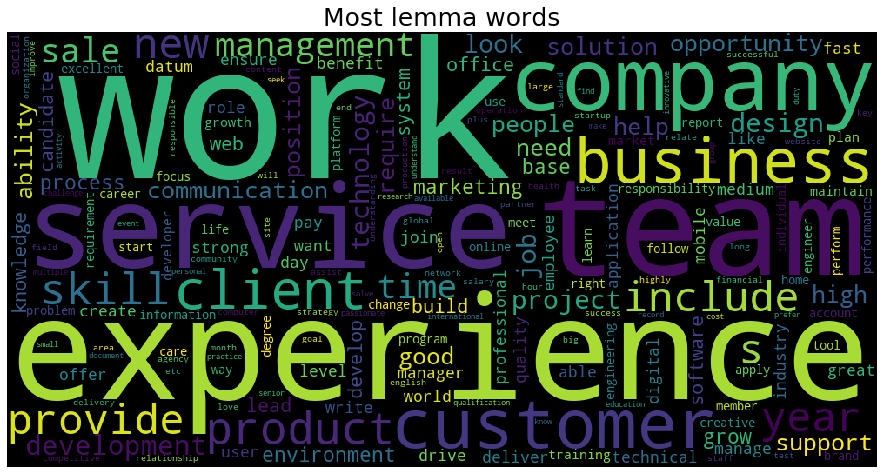

In [136]:
dict_word_freq_lemme = list_to_bow(list(pd_token['lemme']))
wordcloud = WordCloud(width = 1000, height = 500, normalize_plurals=True).generate_from_frequencies(dict_word_freq_lemme)
plt.figure(figsize=(20,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.title("Most lemma words", fontsize=25)
plt.show

#### Create bag of words with clean text ordered by descending frequency

Bag of words size: (4156833, 94605)
Unique words size: 99888


<function matplotlib.pyplot.show(*args, **kw)>

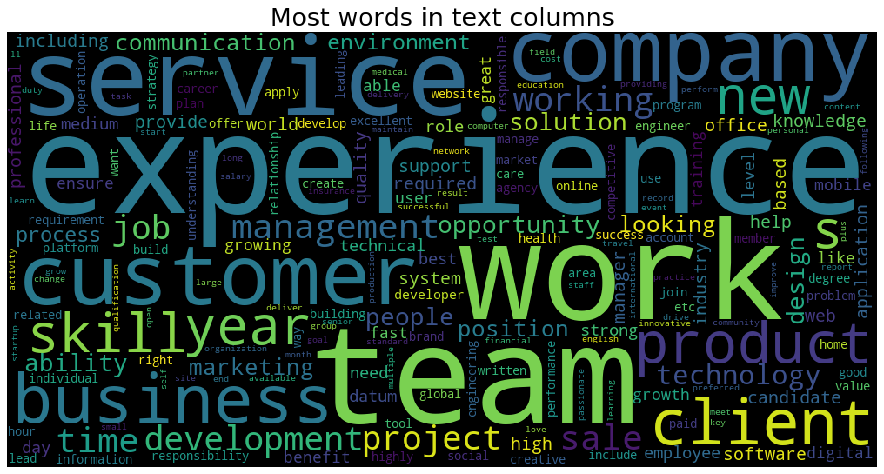

In [137]:
dict_word_freq_texts = list_to_bow(list(pd_token['text_to_singular']))
wordcloud = WordCloud(width = 1000, height = 500, normalize_plurals=True).generate_from_frequencies(dict_word_freq_texts)
plt.figure(figsize=(20,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.title("Most words in text columns", fontsize=25)
plt.show

#### Create bag of words with text of Company info: company_profile, description

Bag of words size: (2830440, 58783)
Unique words size: 61743


<function matplotlib.pyplot.show(*args, **kw)>

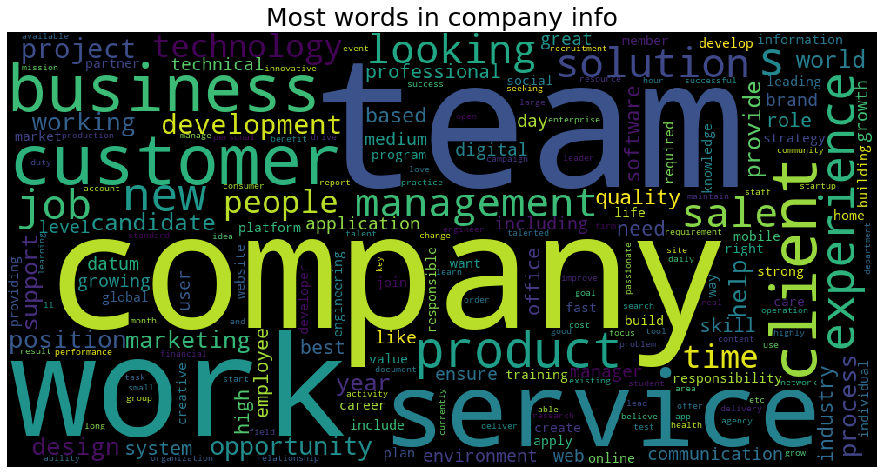

In [138]:
dict_word_freq_company = list_to_bow(list(pd_token[pd_token['column'].isin(company)]['text_to_singular']))
wordcloud = WordCloud(width = 1000, height = 500, normalize_plurals=True).generate_from_frequencies(dict_word_freq_company)
plt.figure(figsize=(20,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.title("Most words in company info", fontsize=25)
plt.show

#### Create bag of words with text of Offer info: title, requirements, benefits

Bag of words size: (1326393, 55187)
Unique words size: 58135


<function matplotlib.pyplot.show(*args, **kw)>

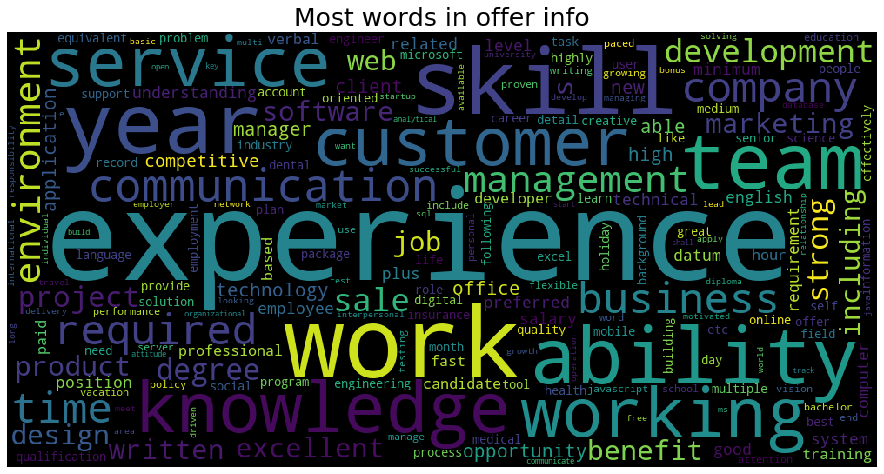

In [139]:
dict_word_freq_offer = list_to_bow(list(pd_token[pd_token['column'].isin(offer)]['text_to_singular']))
wordcloud = WordCloud(width = 1000, height = 500, normalize_plurals=True).generate_from_frequencies(dict_word_freq_offer)
plt.figure(figsize=(20,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.title("Most words in offer info", fontsize=25)
plt.show

### Apply cleaned info to the dataset and store it into a pickle

In [143]:
df_data['company_clean'] = df_data['company'].apply(lambda x: apply_cleaning(x))
df_data['offer_clean']   = df_data['offer'].apply(lambda x: apply_cleaning(x))
df_data['company_lemma'] = df_data['company'].apply(lambda x: apply_lemma(x))
df_data['offer_lemma']   = df_data['offer'].apply(lambda x: apply_lemma(x))
df_data.head()

,job_id,fraudulent,company_profile,description,title,requirements,benefits,company,offer,company_clean,offer_clean,company_lemma,offer_lemma
0,1,0,"we're food52, and we've created a groundbreaki...","food52, a fast-growing, james beard award-winn...",marketing intern,experience with content management systems a m...,,"We're Food52, and we've created a groundbreaki...",Marketing Intern Experience with content manag...,food52 created groundbreaking award winning co...,marketing intern experience content management...,food52 create groundbreaking award win cooking...,market intern experience content management sy...
1,2,0,"90 seconds, the worlds cloud video production ...",organised - focused - vibrant - awesome do you...,customer service - cloud video production,what we expect from you your key responsibilit...,what you will get from usthrough being part of...,"90 Seconds, the worlds Cloud Video Production ...",Customer Service - Cloud Video Production What...,seconds worlds cloud video production service ...,customer service cloud video production expect...,second world cloud video production service se...,customer service cloud video production expect...
2,3,0,valor services provides workforce solutions th...,"our client, located in houston, is actively se...",commissioning machinery assistant cma,implement pre-commissioning and commissioning ...,,Valor Services provides Workforce Solutions th...,Commissioning Machinery Assistant (CMA) Implem...,valor services provides workforce solutions me...,commissioning machinery assistant cma implemen...,valor services provide workforce solution meet...,commission machinery assistant cma implement p...
3,4,0,our passion for improving quality of life thro...,the company esri environmental systems rese...,account executive - washington dc,"education bachelor s or master s in gis, busi...",our culture is anything but corporate we have ...,Our passion for improving quality of life thro...,Account Executive - Washington DC EDUCATION: B...,passion improving quality life geography heart...,account executive washington dc education bach...,passion improve quality life geography heart e...,account executive washington dc education bach...
4,5,0,spotsource solutions llc is a global human cap...,job title itemization review managerlocation ...,bill review manager,qualifications rn license in the state of texa...,full benefits offered,SpotSource Solutions LLC is a Global Human Cap...,Bill Review Manager QUALIFICATIONS:RN license ...,spotsource solutions llc global human capital ...,bill review manager qualifications rn license ...,spotsource solutions llc global human capital ...,bill review manager qualification rn license s...


In [110]:
df_data.to_pickle('data/pickles/clean_text_columns.pkl') #export pickle

In [128]:
### Import of the clean text data

#infile = open('data/pickles/clean_text_columns.pkl','rb')
#data_text = pickle.load(infile)
#infile.close()

In [130]:
data_text = data_text.fillna('')
text_columns = data_text[['job_id']]
text_columns['text'] = data_text.iloc[:,1:].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

### Merge the text columns into one global

In [144]:
text_columns = pd.DataFrame()
text_columns['text'] = df_data[['company_lemma', 'offer_lemma']].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

In [145]:
text_columns.head()

,text
0,food52 create groundbreaking award win cooking...
1,second world cloud video production service se...
2,valor services provide workforce solution meet...
3,passion improve quality life geography heart e...
4,spotsource solutions llc global human capital ...


In [146]:
## Check if there are any null values

text_columns['text'].isnull().sum()

0

### TF-IDF

In [147]:
tfidf = TfidfVectorizer().fit_transform(text_columns['text'])

In [ ]:
raise SystemExit("Stop right there! The following cell takes time to complete.")

In [148]:
embedding = umap.UMAP(metric='hellinger', random_state=42).fit_transform(tfidf)

In [149]:
# Transformación de los embbeding a positivos
embedding_positive = embedding+20
embedding_positive

array([[28.641079, 33.066105],
       [22.401712, 28.12957 ],
       [18.843557, 29.256556],
       ...,
       [18.696371, 31.252613],
       [25.035639, 26.705463],
       [26.631985, 27.661388]], dtype=float32)

In [150]:
text_colums_umap = pd.DataFrame(embedding_positive)

### Merge

In [156]:
result = pd.concat([categorical_columns_dummies, numerical_columns, text_colums_umap], axis=1,levels=None ,sort=False)

In [157]:
result.drop('job_id',axis =1 ,inplace =True)
result.head()

,employment_type_contract,employment_type_full-time,employment_type_other,employment_type_part-time,employment_type_temporary,required_experience_associate,required_experience_entry level,required_experience_executive,required_experience_internship,required_experience_other,...,Country_GR,Country_OTHER,Country_US,telecommuting,has_company_logo,has_questions,fraudulent,salary_range,0,1
0,0,0,1,0,0,0,0,0,1,0,...,0,0,1,0,1,0,0,0.0,28.641079,33.066105
1,0,1,0,0,0,0,0,0,0,1,...,0,1,0,0,1,0,0,1.0,22.401712,28.129570
2,0,0,1,0,0,0,0,0,0,1,...,0,0,1,0,1,0,0,0.0,18.843557,29.256556
3,0,1,0,0,0,1,0,0,0,0,...,0,0,1,0,1,0,0,0.0,13.592897,34.369217
4,0,1,0,0,0,1,0,0,0,0,...,0,0,1,0,1,1,0,0.0,28.738365,28.808285


In [91]:
#result.to_csv('data/result.csv')

## 3.- Model building and evaluation

### Undersampling of the dataset (due a big differences in number of fraudulent vs non-fraudulent jobs)

In [77]:
Ramdom_sample = InstanceHardnessThreshold(random_state =42)

X_rus, y_rus = Ramdom_sample.fit_resample(result.drop('fraudulent', axis = 1), result['fraudulent'])

In [78]:
## Split dataset
X_train_rus, X_test_rus, y_train_rus, y_test_rus = train_test_split(X_rus, y_rus, random_state=42, test_size=0.2)

In [85]:
def baseline_report(model, X_train, X_test, y_train, y_test, name):
    strat_k_fold = StratifiedKFold(n_splits=5, shuffle=True)
    model.fit(X_train, y_train)
    accuracy     = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='accuracy'))
    precision    = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='precision'))
    recall       = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='recall'))
    f1score      = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='f1'))
    rocauc       = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='roc_auc'))
    y_pred = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_pred, y_test).ravel()
    specificity = tn / (tn+fp)

    df_model = pd.DataFrame({'model'        : [name],
                             'accuracy'     : [accuracy],
                             'precision'    : [precision],
                             'recall'       : [recall],
                             'f1score'      : [f1score],
                             'rocauc'       : [rocauc],
                             'specificity': [specificity]
                            })   
    return df_model

In [89]:
models = {'gnb': GaussianNB(),
          'bnb': BernoulliNB(),
          'mnb': MultinomialNB(),
          'logit': LogisticRegression(),
          'knn': KNeighborsClassifier(),
          'decisiontree': DecisionTreeClassifier(),
          'randomforest': RandomForestClassifier(),
          'svc': SVC(probability=True),
          'linearsvc': LinearSVC(),
          'xgboost': GradientBoostingClassifier(),
          'NN': MLPClassifier()
         }

In [ ]:
raise SystemExit("Stop right there! The following cell takes some time to complete.")

In [90]:
# Evaluation of models
models_df = pd.concat([baseline_report(model, X_train_rus, X_test_rus, y_train_rus, y_test_rus, name) 
                       for (name, model) in models.items()]).sort_values('specificity', ascending=True)
models_df

C:\Users\unoma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\unoma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\unoma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\unoma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\unoma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linea

C:\Users\unoma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\unoma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\unoma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\User

C:\Users\unoma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\unoma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\unoma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\unoma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\unoma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:9

C:\Users\unoma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\unoma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\unoma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\unoma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum

,model,accuracy,precision,recall,f1score,rocauc,specificity
0,linearsvc,0.951869,0.833782,0.390884,0.591938,0.939635,0.947432
0,mnb,0.942919,0.658749,0.347657,0.461149,0.884332,0.950390
0,logit,0.957737,0.794589,0.517205,0.618382,0.943154,0.962093
0,svc,0.967283,0.975311,0.524388,0.690359,0.962312,0.964565
0,bnb,0.910601,0.405454,0.599116,0.478067,0.896059,0.968695
0,randomforest,0.985879,0.979541,0.830473,0.877427,0.982456,0.984861
0,xgboost,0.977725,0.936036,0.729908,0.815715,0.984079,0.986481
0,NN,0.981901,0.900499,0.785930,0.850699,0.983055,0.986876
0,knn,0.983890,0.936966,0.804594,0.878622,0.964283,0.986914
0,decisiontree,0.984387,0.884380,0.861984,0.874336,0.928885,0.990638


In [ ]:
## TO-DO 
  # Check the performance of the models with the test (althought specificity is excellent)
  # Check the variance between different validations 
    # (we are seeing only the mean, but there is high variance in the predictions between models??)

## 4. Hyperparameter Tunning of the Models

Althought the metrics of the different models are really good, we can still improve the performance of the models. Therefore, a fine tunning of the different parameters of each models has to be done.

In [ ]:
## 4.1 KNN Tunning

In [ ]:
## 4.2 RandomForest

In [ ]:
## 4.3 MLP